# Módulo 4 - Projeto 2: *SVR, Grid Search & Random Search*

Professora: Esther Colombini -- esther@ic.unicamp.br

Monitora: Alana Santana -- a229999@dac.unicamp.br

Alunos:
*   André Dorte Dos Santos
*   Luiz Massao Miyazaki


André Dorte dos Santos
Luiz Massao Miyazaki

Este *notebook* faz parte da disciplina INF-0616 no curso de extensão MDC.  
Demais artefatos podem ser encontrados no moodle da disciplina:
[moodle.lab.ic.unicamp.br/391](https://moodle.lab.ic.unicamp.br/moodle/course/view.php?id=391)

Instituto de Computação - Unicamp 2020

In [ ]:
  from __future__ import print_function

from math import ceil

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn import datasets
from sklearn.model_selection import train_test_split

import seaborn as sns

from IPython.display import display

from google.colab import files

import io

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## PARTE I - Support Vector Machine Regressors

O conjunto *Doctor fees prediction* contém uma relação entre um conjunto de características associadas à um médico atendente e o preço da consulta cobrada. O objetivo é **regredir** este valor o mais próximo possível do valor esperado.   
Ele pode ser encontrado no moodle, junto com a atividade, ou no seguinte link: [kaggle.com/nitin194/doctor-fees-prediction](https://www.kaggle.com/nitin194/doctor-fees-prediction)

In [ ]:
# requisita um upload de arquivo
# então selecionamos o arquivo doctor-fees-train.csv do armazenamento local
uploaded = files.upload()

Saving doctor-fees-train.csv to doctor-fees-train.csv


In [ ]:
#train = pd.read_csv('./doctor-fees-train.csv')
train = pd.read_csv(io.BytesIO(uploaded['doctor-fees-train.csv']))
train, test = train_test_split(train, test_size=.3, random_state=7128)

#### Pre-processamento dos dados para um formato mais limpo

- Converte a coluna `Rating` para porcentagens
- Converte a coluna `Experience` para um número (em anos)
- Simplifica as colunas `Qualification` e `Place`, removendo caracteres especiais e transformando tudo em minúsculo

In [ ]:
def preprocess(frame):
    frame['Rating'] = frame['Rating'].str.replace('%', '').astype(float) / 100.0
    frame['Experience'] = frame['Experience'].str.replace('years experience', '').astype(float)
    frame['Qualification'] = frame['Qualification'].str.replace('[^a-zA-Z]', ' ').str.lower()
    frame['Place'] = frame['Place'].str.replace('[^a-zA-Z]', ' ').str.lower()

preprocess(train)
preprocess(test)

- Remove uma linha inválida, contendo `"years experience"` como valor para a coluna qualificação

In [ ]:
invalid_rows = train['Qualification'].str.contains('years experience')
train = train[~invalid_rows]

- Preenche todas as células das colunas `Place` e `Profile` com valor igual à `NaN` com a tag `unknown`

In [ ]:
train.fillna({'Place': 'unknown', 'Profile': 'unknown'}, inplace=True);
test.fillna({'Place': 'unknown', 'Profile': 'unknown'}, inplace=True);
train.head()

,Qualification,Experience,Rating,Place,Profile,Miscellaneous_Info,Fees
387,bds mds conservative dentistry endodontics,6.0,NaN,nungambakkam chennai,Dentist,RCT - Root Canal Treatment Dental Fillings Den...,500
1162,mbbs,9.0,NaN,balapur hyderabad,General Medicine,"Balapur, Hyderabad ₹300 Visits Today",300
4593,md dermatology venereology leprosy mbbs,17.0,NaN,manikonda hyderabad,Dermatologists,NaN,350
1992,bams,10.0,1.0,konanakunte bangalore,Ayurveda,"100% 18 Feedback Konanakunte, Bangalore",150
2641,bhms,0.0,NaN,vidyanagar hyderabad,Homeopath,NaN,200


### Exibindo frequência com que as qualificações, locais e perfis ocorrem nos conjuntos

In [ ]:
def plot_feature_freq(frame, feature, showing=30):
    labels, counts = np.unique(frame[feature].dropna(), return_counts=True)

    # ordena pelas mais frequentes
    p = np.argsort(counts)[::-1]
    labels, counts = labels[p], counts[p]

    g = sns.barplot(labels[:showing], counts[:showing])
    g.set_xticklabels(labels[:showing], rotation=90)

    return g

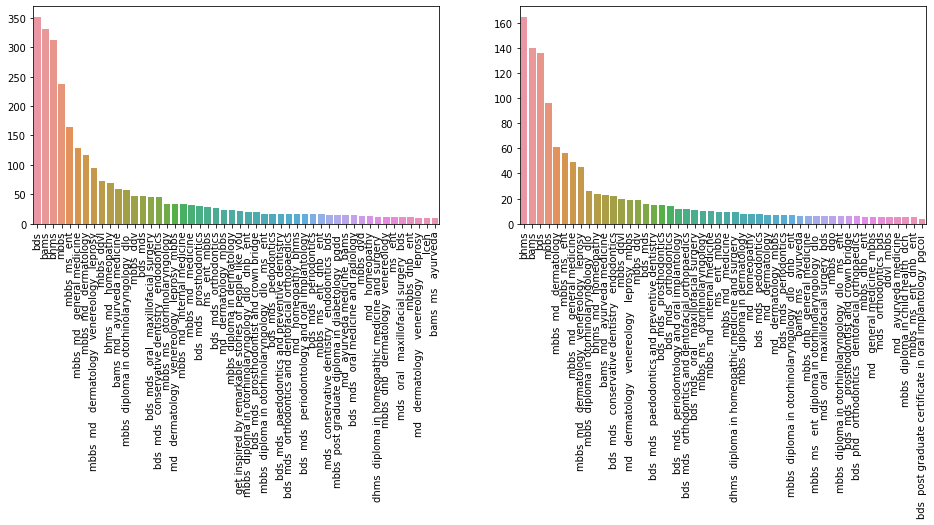

In [ ]:
plt.figure(figsize=(16, 4))

plt.subplot(121)
plot_feature_freq(train, 'Qualification', showing=50)

plt.subplot(122)
plot_feature_freq(test, 'Qualification', showing=50)

# Ordena as qualificações pelas mais frequentes.
qualifications, counts = np.unique(train['Qualification'].dropna(), return_counts=True)
p = np.argsort(counts)[::-1]
qualifications = qualifications[p];

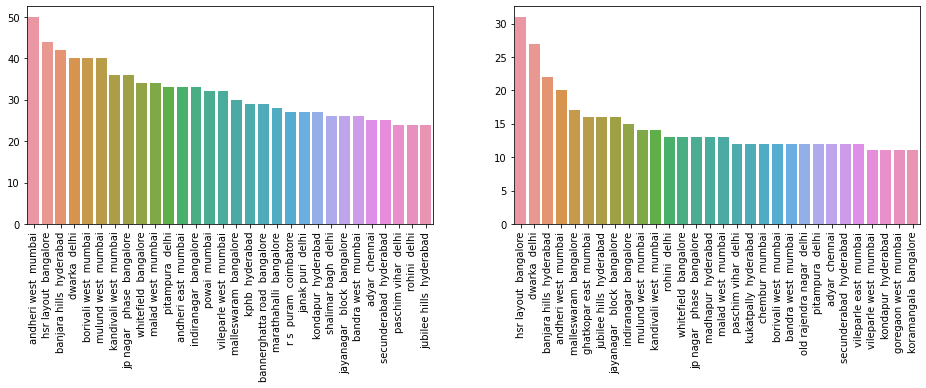

In [ ]:
plt.figure(figsize=(16, 4))

plt.subplot(121)
plot_feature_freq(train, 'Place')

plt.subplot(122)
plot_feature_freq(test, 'Place')

# Ordena os locais pelos mais frequentes.
places, counts = np.unique(train['Place'].dropna(), return_counts=True)
p = np.argsort(counts)[::-1]
places = places[p];

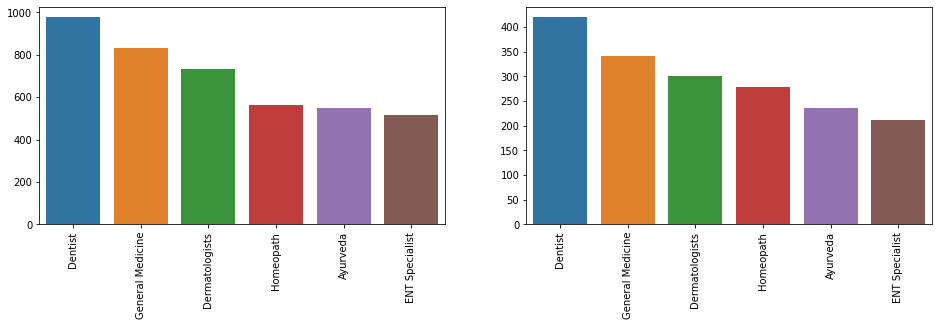

In [ ]:
plt.figure(figsize=(16, 4))

plt.subplot(121)
plot_feature_freq(train, 'Profile')

plt.subplot(122)
plot_feature_freq(test, 'Profile');

### Modelando um regressor de custo de consulta

In [ ]:
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer

Vamos codificar as características categóricas usando o one-hot encoding.
Entretanto, dado o alto número de ocorrências únicas, nós consideramos somente os 100 valores de maior frequência.

In [ ]:
retained_qualif = qualifications[:100].tolist()
retained_places = places[:100].tolist()

qualif_places_enc = OneHotEncoder(categories=[retained_qualif, retained_places],
                                  handle_unknown='ignore')
profile_enc = OneHotEncoder()

Imputamos (substituímos as células desconhecidas pelo valor mediano) e normalizamos as características contínuas com o `StandardScaler`, o que os transforma em um conjunto de média 0, desvio padrão 1:

In [ ]:
continuous_enc = make_pipeline(SimpleImputer(strategy='median'),
                               StandardScaler())

Compomos o pipeline, definindo quais colunas alimentarão quais codificadores, e aplicamos o transformador aos dados de entrada e aos valores de saída:

In [ ]:
encoder = ColumnTransformer([
  ('q_pla', qualif_places_enc, ['Qualification', 'Place']),
  ('prof', profile_enc, ['Profile']),
  ('ex_ra', continuous_enc, ['Experience', 'Rating'])
])

train_e = encoder.fit_transform(train)
test_e = encoder.transform(test)

fee_enc = StandardScaler()
ye_train = fee_enc.fit_transform(train[['Fees']].astype(float)).ravel()
ye_test = fee_enc.transform(test[['Fees']].astype(float)).ravel()

**Atividade (5 pts):** treine três ou mais regressores baseados em *máquina de vetor de suporte* com configurações distintas (Kernel, C, epislon) e reporte o seus respectivos erros quadráticos médios (MSE) sobre as porções de validação separadas. Discuta como os diversos parâmetros da SVR (Kernel, C, epislon) afetaramm a qualidade do seus regressores.

Utilize o conjunto transformado pelas células acima `(train_e, ye_train)`.

In [ ]:
np.random.seed(1082141)
sns.set()

In [ ]:
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
import array
from sklearn.model_selection import validation_curve

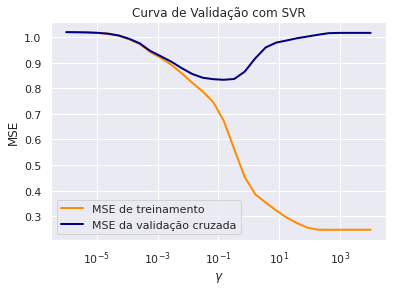

In [ ]:
# Gamma variation

param_range = np.logspace(-6, 4, 30)
train_scores, test_scores = validation_curve(
    SVR(kernel='rbf'), train_e, ye_train, param_name="gamma", param_range=param_range,
    cv=10, scoring="neg_mean_squared_error", n_jobs=1)
train_scores_mean = -1.0 * np.mean(train_scores, axis=1)
test_scores_mean = -1.0 * np.mean(test_scores, axis=1)

plt.title("Curva de Validação com SVR")
plt.xlabel("$\gamma$")
plt.ylabel("MSE")

lw = 2
plt.semilogx(param_range, train_scores_mean, label="MSE de treinamento",
             color="darkorange", lw=lw)
plt.semilogx(param_range, test_scores_mean, label="MSE da validação cruzada",
             color="navy", lw=lw)
plt.legend(loc="best")
plt.show()

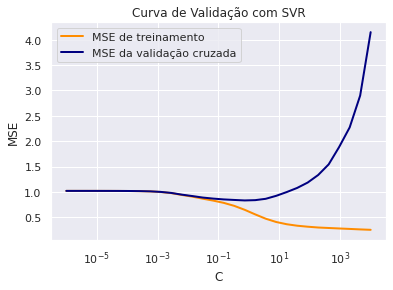

In [ ]:
# C variation

param_range = np.logspace(-6, 4, 30)
train_scores, test_scores = validation_curve(
    SVR(kernel='rbf'), train_e, ye_train, param_name="C", param_range=param_range,
    cv=10, scoring="neg_mean_squared_error", n_jobs=1)
train_scores_mean = -1.0 * np.mean(train_scores, axis=1)
test_scores_mean = -1.0 * np.mean(test_scores, axis=1)

plt.title("Curva de Validação com SVR")
plt.xlabel("C")
plt.ylabel("MSE")

lw = 2
plt.semilogx(param_range, train_scores_mean, label="MSE de treinamento",
             color="darkorange", lw=lw)
plt.semilogx(param_range, test_scores_mean, label="MSE da validação cruzada",
             color="navy", lw=lw)
plt.legend(loc="best")
plt.show()

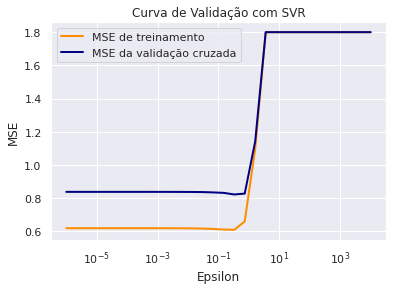

In [ ]:
# Epsilon variation

param_range = np.logspace(-6, 4, 30)
train_scores, test_scores = validation_curve(
    SVR(kernel='rbf'), train_e, ye_train, param_name="epsilon", param_range=param_range,
    cv=10, scoring="neg_mean_squared_error", n_jobs=1)
train_scores_mean = -1.0 * np.mean(train_scores, axis=1)
test_scores_mean = -1.0 * np.mean(test_scores, axis=1)

plt.title("Curva de Validação com SVR")
plt.xlabel("Epsilon")
plt.ylabel("MSE")

lw = 2
plt.semilogx(param_range, train_scores_mean, label="MSE de treinamento",
             color="darkorange", lw=lw)
plt.semilogx(param_range, test_scores_mean, label="MSE da validação cruzada",
             color="navy", lw=lw)
plt.legend(loc="best")
plt.show()

Pelos gráficos acima, podemos notar que aumentando os valores das variáveis **gamma** e **C** o regressor tem resultados melhores até um ponto ótimo, após esse ponto se continuarmos aumentando e erro volta a piorar no conjunto de teste.

Para o conjunto de treinamento **gamma** e **C** continuam a aumentar conforme aumentamos seus valores, mas se trata de um overfitting.

Para o **epsilon** notamos que se mantêm quase constante ao aumentarmos seu valor, porém entre 0.1 e 1 ele diminiu o erro, após isso o erro sobe de forma brusca e atinge um máximo entre 1 e 10 onde o erro permanece constante.

Pelos gráficos acima, podemos avaliar o desempenho de muitos regressores, variando os valores de **gamma**, **C** e **epsilon** entre 10^(-6) e 10^4. Além disso o eixo Y do gráfico representa o erro quadrático médio (MSE).

In [ ]:
# regressor linear vs regressor não-linear

regressor = SVR(kernel='linear').fit(train_e, ye_train)
prediction = regressor.predict(test_e)
print("Liner MSE = ", mean_squared_error(ye_test, prediction))

regressor = SVR(kernel='rbf').fit(train_e, ye_train)
prediction = regressor.predict(test_e)
print("RBF MSE = ", mean_squared_error(ye_test, prediction))


Liner MSE =  0.8843556879948028
RBF MSE =  0.8038962243450666


Analisando os erros quadráticos médio do regressor com **kernel linear** versus o MSE do regressor com **kernel rbf**, podemos notar que o **kernel rbf** possui melhor resultado para o conjunto de teste.

## PARTE II - Classificando imagens de dígitos
### Lendo o conjunto de dados

**Pen-Based Recognition of Handwritten Digits Data Set**
é um banco de imagens simples e bem conhecido em reconhecimento de imagens.  
Ele é composto por imagens em escala cinza de 8 por 8 pixels divididas em 10 classes de dígitos.

Uma descrição completa pode ser encontrada no seguinte link: [archive.ics.uci.edu/ml/datasets/Pen-Based+Recognition+of+Handwritten+Digits](http://archive.ics.uci.edu/ml/datasets/Pen-Based+Recognition+of+Handwritten+Digits)

In [ ]:
x, y = datasets.load_digits(return_X_y=True)

x_train, x_test, y_train, y_test = train_test_split(x, y,
                                                    test_size=.5,
                                                    random_state=183212)
print('amostras em treino: %i' % x_train.shape[0],
      'amostras em teste: %i' % x_test.shape[0],
      'número de características: %i' % x_train.shape[1],
      'número de classes: %i' % (np.max(y_train) + 1),
      sep='\n', end='\n\n')

amostras em treino: 898
amostras em teste: 899
número de características: 64
número de classes: 10



### 64 primeiras amostras no conjunto de treinamento

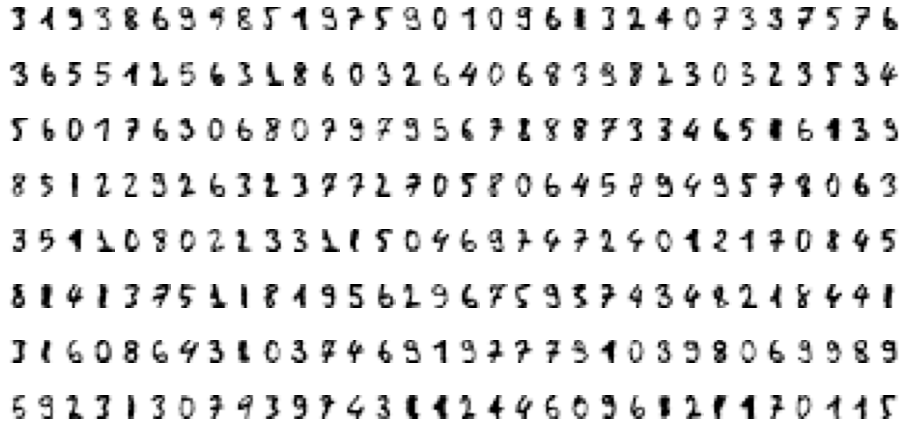

In [ ]:
plt.figure(figsize=(16, 8))

for ix in range(8  * 32):
    plt.subplot(8, 32, ix + 1)
    plt.imshow(x_train[ix].reshape(8, 8), cmap='Greys')
    plt.axis('off')

### Visualizando o conjunto e frequências das classes

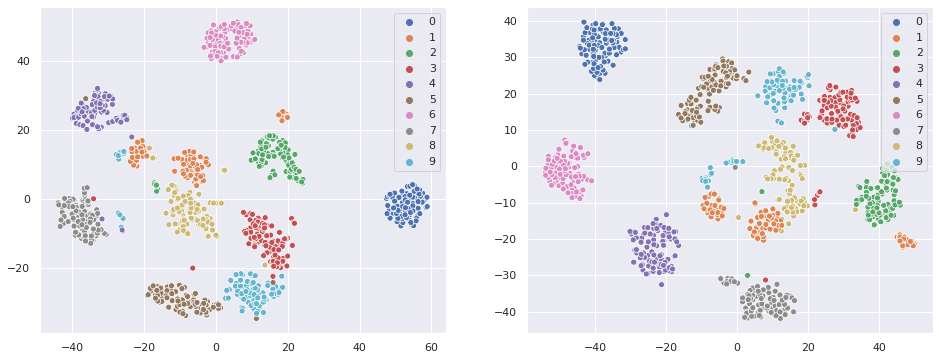

In [ ]:
from sklearn.manifold import TSNE

encoder2D = TSNE()
w_train = encoder2D.fit_transform(x_train)
w_test = encoder2D.fit_transform(x_test)

plt.figure(figsize=(16, 6))
categorical_colors = sns.color_palette()

for ix, (x, y) in enumerate(((w_train, y_train), (w_test, y_test))):
    plt.subplot(1, 2, ix + 1)
    sns.scatterplot(*x.T, hue=y, palette=categorical_colors);

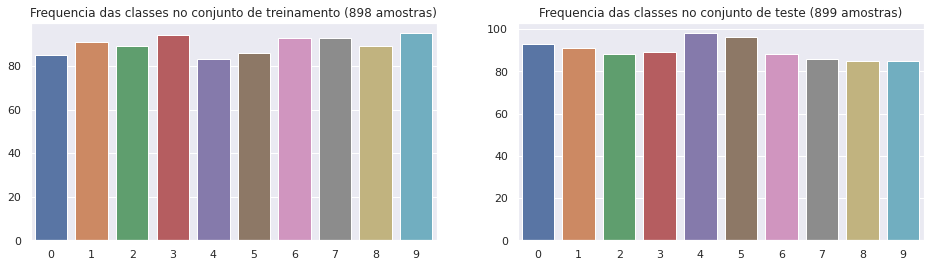

In [ ]:
plt.figure(figsize=(16, 4))

plt.subplot(121)
plt.title('Frequencia das classes no conjunto de treinamento (%i amostras)' % len(x_train))
labels, counts = np.unique(y_train, return_counts=True)
sns.barplot(labels, counts)

plt.subplot(122)
plt.title('Frequencia das classes no conjunto de teste (%i amostras)' % len(x_test))
labels, counts = np.unique(y_test, return_counts=True)
sns.barplot(labels, counts);

### Modelando um classificador de digitos com SVM Linear

**Atividade (1 pt):** defina e treine uma máquina de vetor de suporte com kernel linear, utilizando o scikit-learn. Encontre o melhor valor do parâmetro C, definindo um intervalo de busca e fazendo um grid search com validação cruzada em 10 folds.

In [ ]:
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score

# busca o melhor valor de C
C_range = np.logspace(-5, 4, 10)
C_scores = []
for C in C_range:
    svm = SVC(kernel='linear', C=C)
    scores = cross_val_score(svm, x_train, y_train, cv=10, scoring='accuracy')
    C_scores.append(scores.mean())
print(C_range)
print(C_scores)

[1.e-05 1.e-04 1.e-03 1.e-02 1.e-01 1.e+00 1.e+01 1.e+02 1.e+03 1.e+04]
[0.41877652933832704, 0.9420848938826467, 0.9755181023720351, 0.9766541822721599, 0.9766541822721599, 0.9766541822721599, 0.9766541822721599, 0.9766541822721599, 0.9766541822721599, 0.9766541822721599]


Pelos valores mostrado acima, podemos considerar **1.e-02** como o melhor valor de **C**, pois apresenta a melhor acurácia, após esse valor a acurácia permanece constante por alguma iterações, porém como vimos anteriormente se continuarmos aumentando C, vamos gerar overfitting.

### Avaliando o modelo treinado

**Atividade (1 pt):** avalie o modelo treinado com o melhor valor encontrado para o parâmetro C sobre o conjunto de teste previamente separado. Reporte a acurácia média e a matriz de confusão.

Average Accuracy: 0.9766541822721599
Balanced Accurracy: 0.9713788939475048


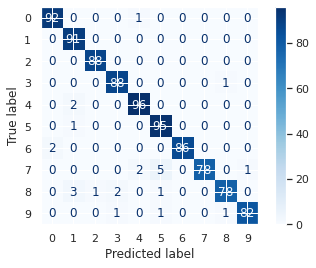

In [ ]:
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import balanced_accuracy_score
import matplotlib.pyplot as plt
from sklearn.svm import SVC

svm = SVC(kernel='linear', C=0.01)
scores = cross_val_score(svm, x_train, y_train, cv=10, scoring='accuracy')
averageAccLinear = scores.mean()

bestModel = SVC(kernel='linear', C=0.01).fit(x_train, y_train)
print(f'Average Accuracy: {averageAccLinear}')
print(f'Balanced Accurracy: {balanced_accuracy_score(y_test, bestModel.predict(x_test))}')
plot_confusion_matrix(bestModel, x_test, y_test, cmap=plt.cm.Blues, normalize=None)

### Modelando um classificador de digitos com SVM com kernel RBF

**Atividade (1 pt):** utilizando o kernel RBF, defina e treine uma máquina de vetor de suporte. Faça um grid search nos valores de C e gamma com validação cruzada em 10 folds.

In [ ]:
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score

# busca o melhor valor de C
C_range = np.logspace(-5, 4, 10)
C_scores = []
for C in C_range:
    svm = SVC(kernel='rbf', C=C)
    scores = cross_val_score(svm, x_train, y_train, cv=10, scoring='accuracy')
    C_scores.append(scores.mean())
print(C_range)
print(C_scores)

[1.e-05 1.e-04 1.e-03 1.e-02 1.e-01 1.e+00 1.e+01 1.e+02 1.e+03 1.e+04]
[0.14932584269662924, 0.14932584269662924, 0.14932584269662924, 0.14932584269662924, 0.928689138576779, 0.9855555555555556, 0.9855555555555556, 0.9855555555555556, 0.9855555555555556, 0.9855555555555556]


In [ ]:
# busca o melhor valor de gamma
g_range = np.logspace(-5, 4, 10)
g_scores = []
for g in g_range:
    svm = SVC(kernel='rbf', gamma=g)
    scores = cross_val_score(svm, x_train, y_train, cv=10, scoring='accuracy')
    g_scores.append(scores.mean())
print(g_range)
print(g_scores)

[1.e-05 1.e-04 1.e-03 1.e-02 1.e-01 1.e+00 1.e+01 1.e+02 1.e+03 1.e+04]
[0.8172784019975031, 0.9621722846441948, 0.99, 0.6982896379525593, 0.11027465667915107, 0.15156054931335833, 0.10580524344569289, 0.10580524344569289, 0.10580524344569289, 0.10580524344569289]


A partir do código acima executamos o grid search para encontrar os melhores valores para **C** e **gamma**.

Os resultado foi:
*   C = 1
*   Gamma = 1.e-03



**Atividade (1 pt):** aumente o intervalo de busca de C e gamma e faça uma busca randômica pelo intervalo.

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

# especifica "parameter distributions" ao invés de "parameter grid"
C_range = np.logspace(-9, 5, 50)
gamma_range = np.logspace(-9, 5,50)
param_dist = dict(gamma=gamma_range, C=C_range)

# n_iter controla o número de buscas
svm = SVC(kernel = 'rbf')
rand = RandomizedSearchCV(svm, param_dist, cv=10, scoring='accuracy', n_iter=10, random_state=5)
rand.fit(x_train, y_train)
rand.cv_results_['mean_test_score']

# melhor modelo
print(rand.best_score_)
print(rand.best_params_)

0.9888888888888889
{'gamma': 0.001, 'C': 1000.0}


### Avaliando os melhores modelos

**Atividade (1 pt):** utilizando o melhor par de valores encontrado para C e gamma, em cada uma das estratégias, treine e avalie um modelo sobre o conjunto de teste previamente separado. Reporte a acurácia média e a matriz de confusão para com cada modelo.

Grid Search Accurracy: 0.9863000659046598
Random Search Accurracy: 0.9864348698262285


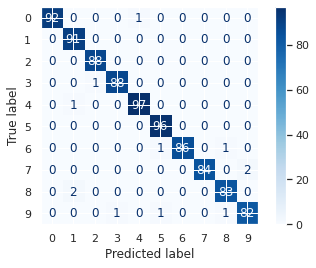

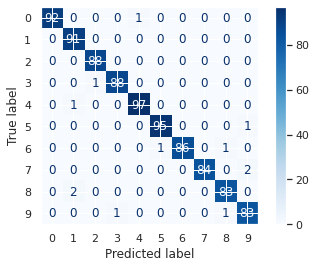

In [ ]:
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import balanced_accuracy_score
import matplotlib.pyplot as plt
from sklearn.svm import SVC

# grid search
gridSearchModel = SVC(kernel='rbf', C=1, gamma=0.001).fit(x_train, y_train)
print(f'Grid Search Accurracy: {balanced_accuracy_score(y_test, gridSearchModel.predict(x_test))}')
plot_confusion_matrix(gridSearchModel, x_test, y_test, cmap=plt.cm.Blues, normalize=None)

# random search
randomSearchModel = SVC(kernel='rbf', C=1000, gamma=0.001).fit(x_train, y_train)
print(f'Random Search Accurracy: {balanced_accuracy_score(y_test, randomSearchModel.predict(x_test))}')
plot_confusion_matrix(randomSearchModel, x_test, y_test, cmap=plt.cm.Blues, normalize=None)


Embora os parâmetros **C** e **gamma** foram obtidos por métodos diferentes, analisando a acurácia média e as matrizes de confusão, podemos notar que ambos regressores trazem bons resultados, com acurácia média acima de 98,6%.